In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from shap import TreeExplainer, decision_plot, Explainer
from shap.plots import beeswarm
import matplotlib.pyplot as plt
df = pd.read_csv('data/strat.csv')
df.dropna(subset=['MPCE_qrt'], inplace=True)

In [2]:
states = pd.read_csv('data/state_codes.csv', header=None, index_col=0)[1].to_dict()
df['state_codes'].replace(states, inplace=True)

In [3]:
df['piped_gas'].unique()

array(['Piped Gas/LPG Present', 'No Piped Gas/LPG'], dtype=object)

In [4]:
# Process binary columns
df['Urban'] = (df['sector'] == 'Urban').astype(int)
df['HH with children below age 6'] = (df['child'] == 'HH with children beloww age 6 ').astype(int)
df['Piped Gas/LPG Present'] = (df['piped_gas'] == 'Piped Gas/LPG Present').astype(int)

In [5]:
# Rename MPCE values
df['MPCE_qrt'].replace({'50-75': 'Third MPCE Quartile', '0-25': 'Lowest MPCE Quartile', '25-50': 'Second MPCE Quartile', '75-100': 'Top MPCE Quartile'}, inplace=True)

In [6]:
def modify_ax(ax, title):
    # ax.set_title('Determinants of Time Spent by Men on Paid Work ($R^{2}$ = 0.73)', fontsize='x-large', pad=20)
    ax.set_title(title, fontsize='x-large', pad=20)
    ax.tick_params(axis='y', labelsize='large')
    ax.set_xlabel('Deviation from average time spent (in hours)', fontsize='large')

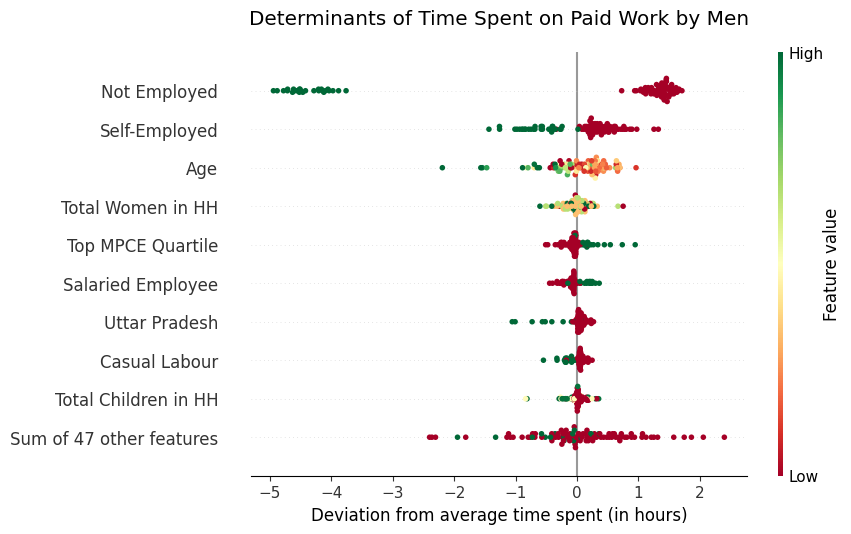

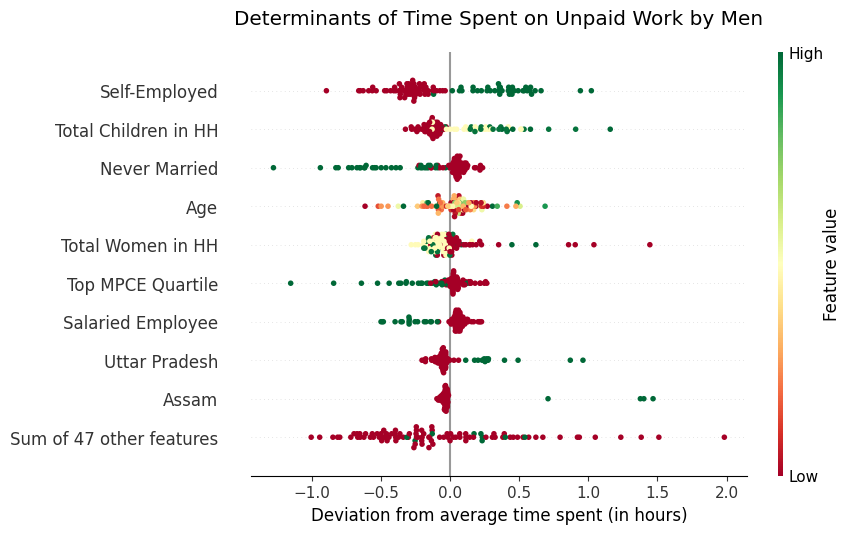

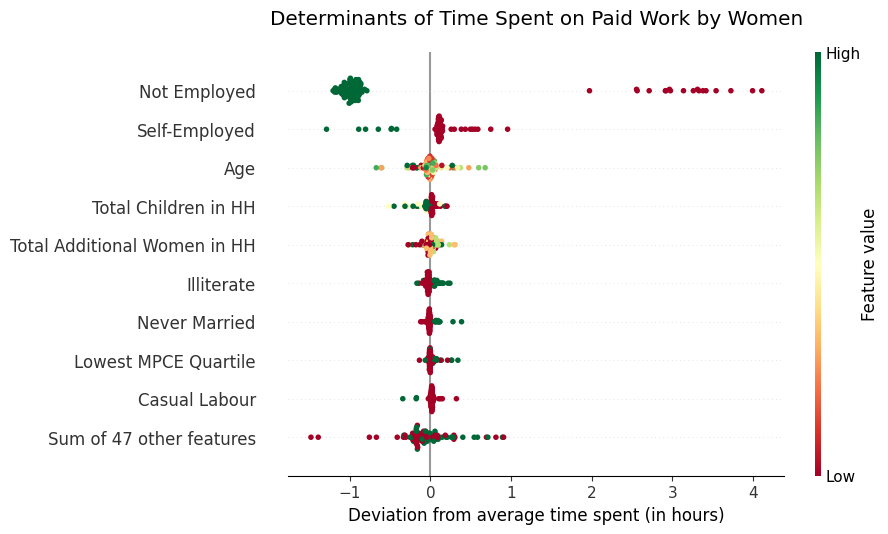

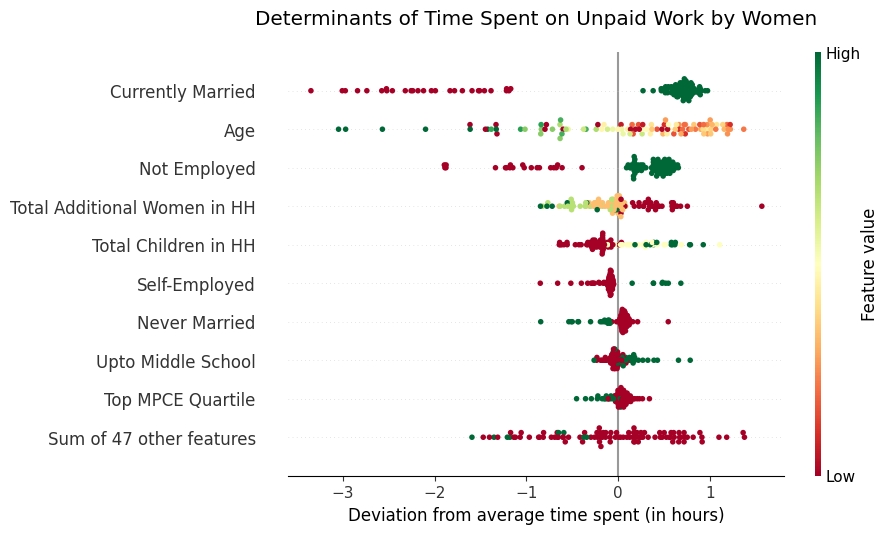

In [15]:
def modify_ax(ax, title):
    # ax.set_title('Determinants of Time Spent by Men on Paid Work ($R^{2}$ = 0.73)', fontsize='x-large', pad=20)
    ax.set_title(title, fontsize='x-large', pad=20)
    ax.tick_params(axis='y', labelsize='large')
    ax.set_xlabel('Deviation from average time spent (in hours)', fontsize='large')
    

for gender, target, spec_col in zip(
    ['Male', 'Male', 'Female', 'Female'],
    ['Time Spent on Paid Work', 'Time Spent on Unpaid Work', 'Time Spent on Paid Work', 'Time Spent on Unpaid Work'],
    ['Total Women in HH', 'Total Women in HH', 'Total Additional Women in HH', 'Total Additional Women in HH']):
    xdf = df[df['Gender'] == gender]
    feats = ['Total Children in HH', spec_col, 'education', 'marital_status', 'employment', 'Age', 'MPCE_qrt', 'state_codes']
    catCols = ['education', 'marital_status', 'employment', 'state_codes', 'MPCE_qrt']
    numCols = [c for c in feats if c not in catCols]
    xCat = pd.get_dummies(xdf[catCols], prefix='', prefix_sep='', drop_first=False, dtype=int)
    xdf = xdf.drop(catCols, axis=1)
    xNum = xdf[numCols]
    y = xdf[target] / 60
    X = pd.concat((xNum, xCat), axis=1)
    X[target] = y
    xtrain, xtest = train_test_split(X, stratify=xdf['stratcode'], test_size=0.2)
    ytrain = xtrain.pop(target)
    ytest = xtest.pop(target)

    clf = RandomForestRegressor(n_estimators=40, n_jobs=-1)
    clf.fit(xtrain, ytrain)
    exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
    vals = exp(xtest.sample(100), check_additivity=False)
    plt.figure()
    beeswarm(vals, color='RdYlGn', show=False)
    tname = "Men" if gender == "Male" else "Women"
    modify_ax(plt.gca(), f"Determinants of {target} by {tname}")

In [7]:
target_names = ['Time Spent on Paid Work',
                'Time Spent on Unpaid Work',
                'Time Spent on Leisure',
                'Time Spent Cooking',
                'Time Spent Cleaning',
                'Time Spent Collecting Firewood',
                'Time Spent Washing',
                'Time Spent on Domestic Chores',
                'Time Spent on Care Work']
resultdf = pd.DataFrame({'target': target_names, 'train': 0, 'test': 0})
xdf = df[df['Gender'] == 'Female']
feats = ['Social_group_', 'religion', 'Urban', 'MPCE_qrt', 'Age', 'education', 'employment', 'marital_status', 'Piped Gas/LPG Present', 'wired_source', 'sweeeping_type', 'HH with children below age 6',
         'old', 'n_unemp_men', 'state_codes']
catCols = feats.copy()
numCols = ['Age', 'n_unemp_men', 'Urban', 'Piped Gas/LPG Present', 'HH with children below age 6']
for numCol in numCols:
    catCols.remove(numCol)


xCat = pd.get_dummies(xdf[catCols], prefix='', prefix_sep='', dtype=int)
xNum = xdf[numCols]
X = pd.concat((xCat, xNum, xdf[target_names + ['stratcode']]), axis=1)

<Axes: >

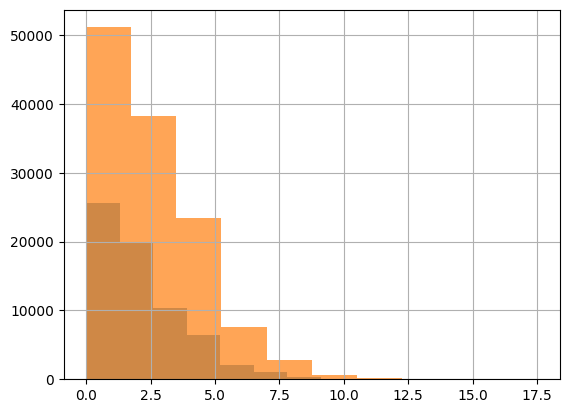

In [18]:
time_with_ch = X[X['HH with children below age 6'] == 1]['Time Spent on Leisure'] / 60
time_wo_ch = X[X['HH with children below age 6'] == 0]['Time Spent on Leisure'] / 60
fig, ax = plt.subplots()
time_with_ch.hist(ax=ax, label='Children below 6', alpha=0.7)
time_wo_ch.hist(ax=ax, label='No children below 6', alpha=0.7)

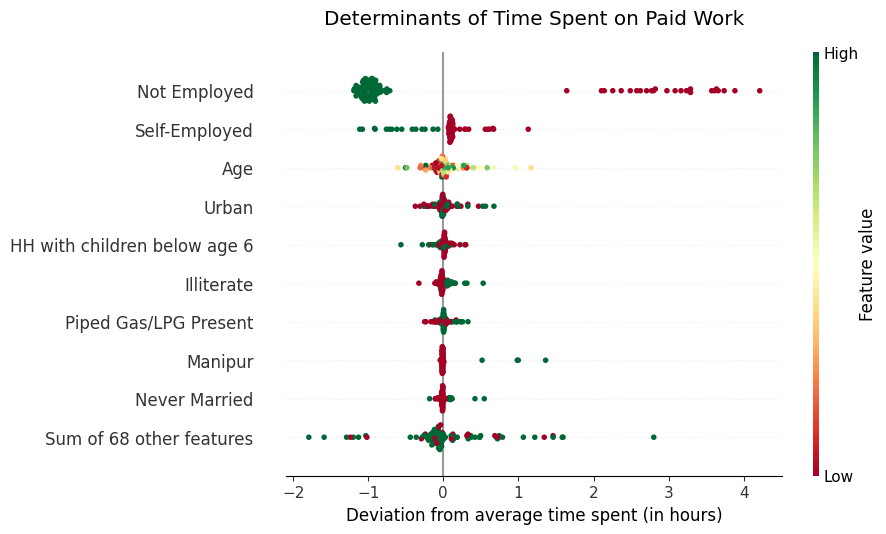

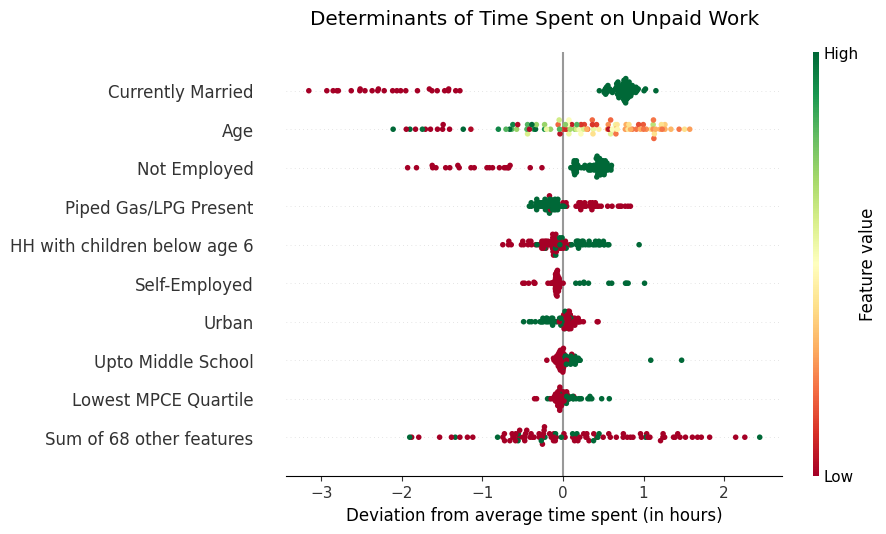

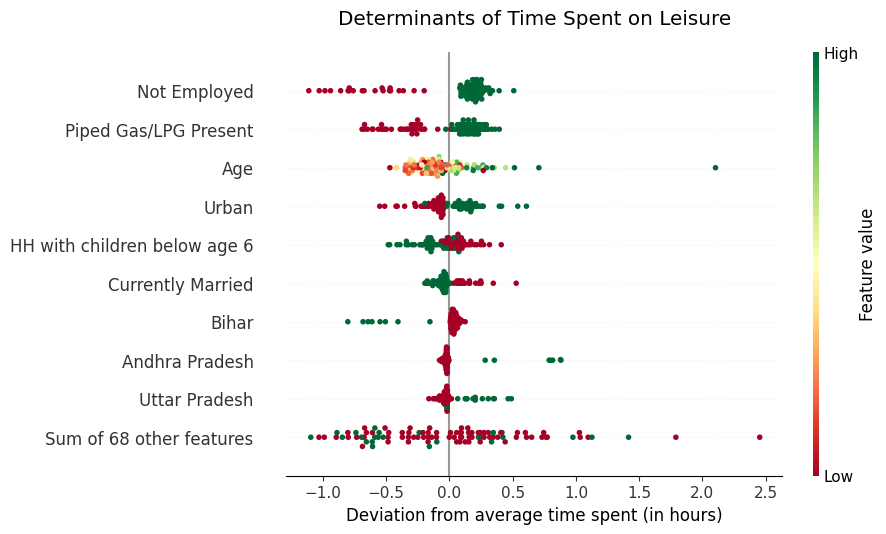

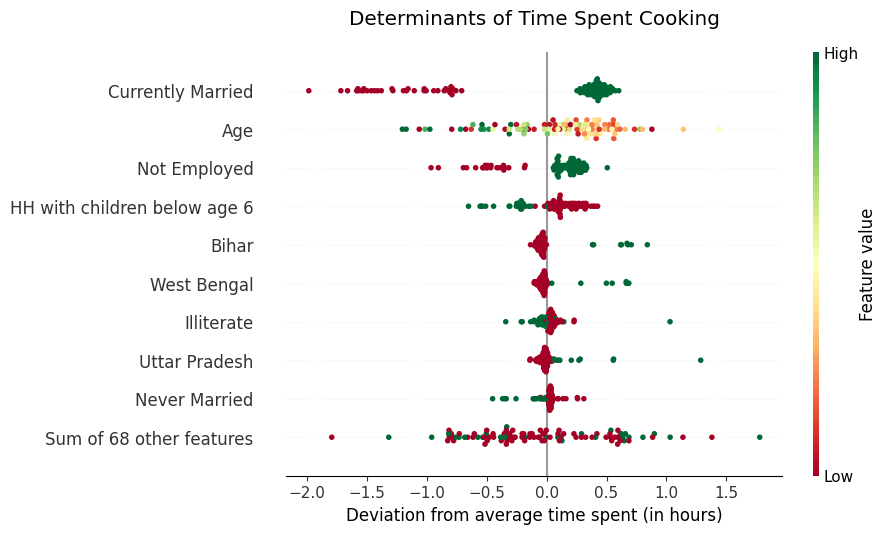

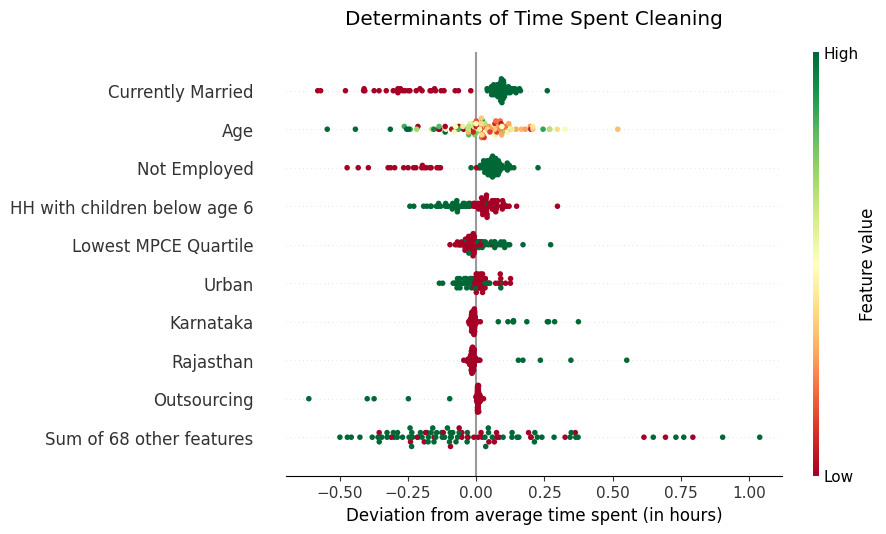

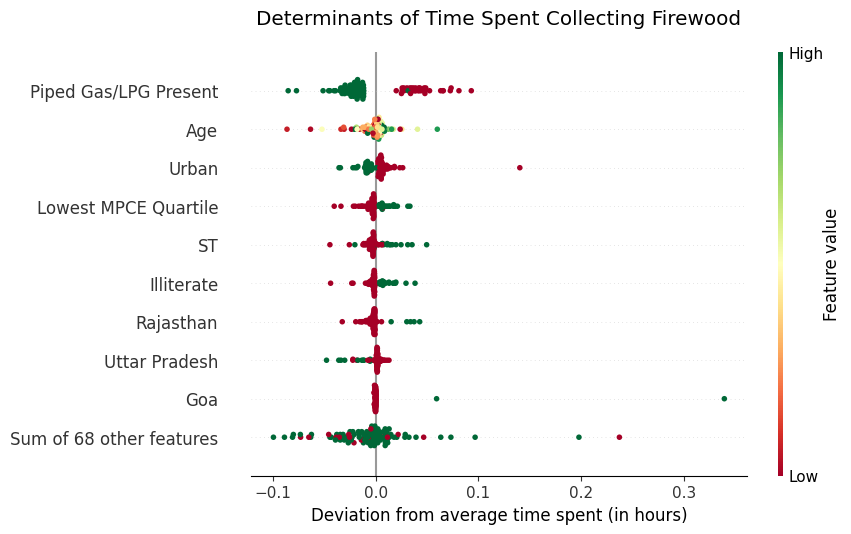

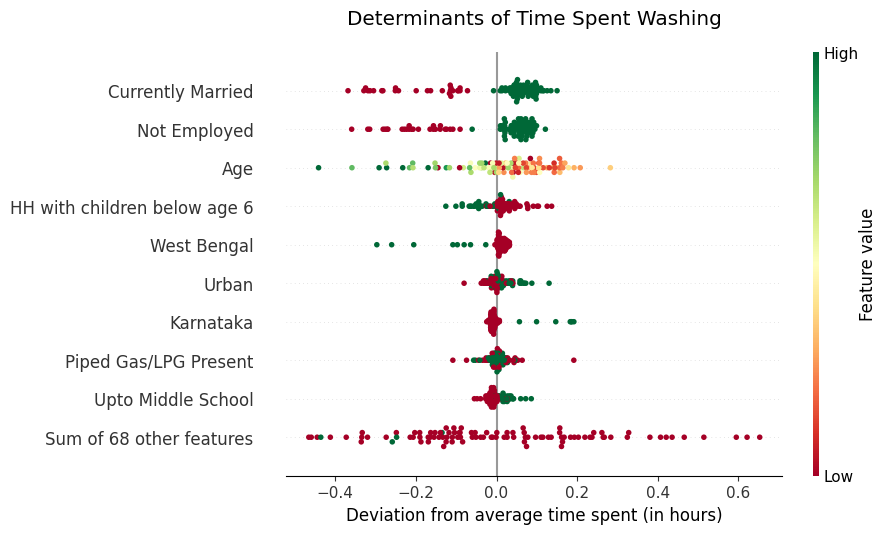

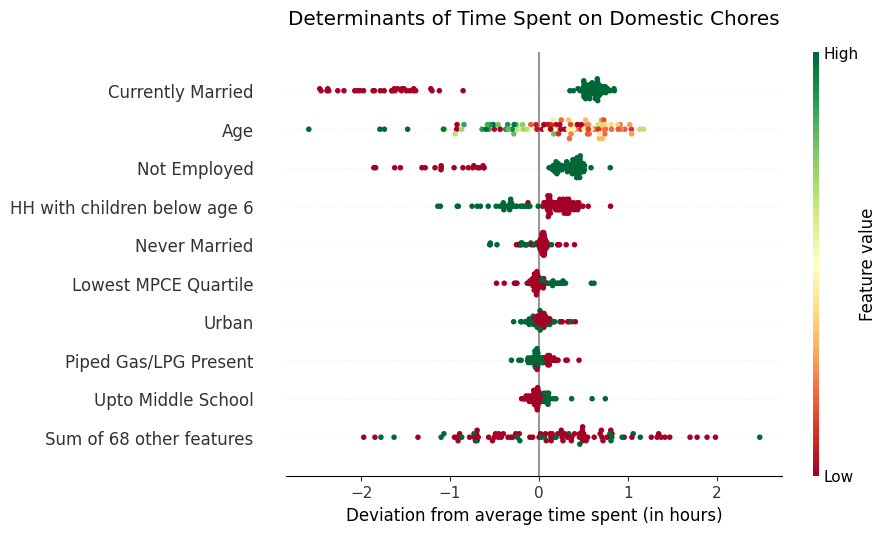

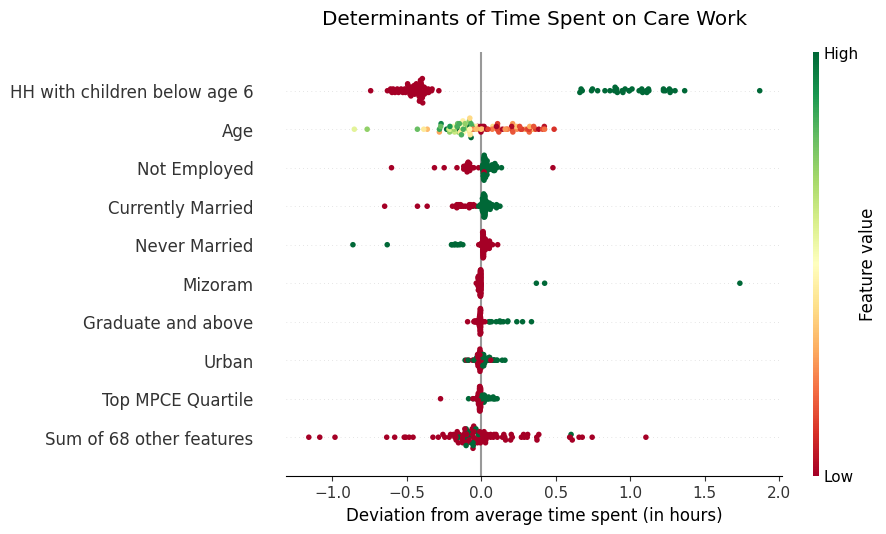

In [11]:
results = []
for t in target_names:
    # xtrain, xtest = train_test_split(X, stratify=X['stratcode'], test_size=0.1)
    # dftrain = xtrain.drop(target_names + ['stratcode'], axis=1)
    # dftest = xtest.drop(target_names + ['stratcode'], axis=1)
    # ytrain = xtrain[t]
    # ytest = xtest[t]
    xtrain = X.drop(target_names + ['stratcode'], axis=1)
    ytrain = X[t]
    clf = RandomForestRegressor(n_jobs=-1)
    clf.fit(xtrain, ytrain / 60)

    exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
    vals = exp(xtrain.sample(100), check_additivity=False)
    plt.figure()
    beeswarm(vals, color='RdYlGn', show=False)
    modify_ax(plt.gca(), f"Determinants of {t}")

In [19]:
pd.DataFrame(results)

,target,score
0,Time Spent on Paid Work,0.471720
1,Time Spent on Unpaid Work,0.400648
2,Time Spent on Leisure,0.031780
3,Time Spent Cooking,0.301376
4,Time Spent Cleaning,-0.033984
5,Time Spent Collecting Firewood,-0.228815
6,Time Spent Washing,-0.000989
7,Time Spent on Domestic Chores,0.332476
8,Time Spent on Care Work,0.303619


In [26]:
pd.DataFrame(results)

""


In [17]:
pd.read_csv('data/cv_results_eqn3.csv')

,Target,RF (Train),RF (Test),DT (Train),DT (Test),LR (Train),LR (Test)
0,Time Spent on Paid Work,0.905003,0.499561,0.963802,0.114214,0.529253,0.526948
1,Time Spent on Unpaid Work,0.875495,0.432615,0.936309,0.051024,0.430881,0.434792
2,Time Spent on Leisure,0.792833,0.081411,0.888682,-0.522495,0.180908,0.178289
3,Time Spent Cooking,0.850811,0.331322,0.921379,-0.112898,0.344989,0.349894
4,Time Spent Cleaning,0.773613,0.024703,0.873661,-0.628305,0.126290,0.119419
5,Time Spent Collecting Firewood,0.733928,-0.147928,0.848987,-0.907321,0.041125,0.037825
6,Time Spent Washing,0.782255,0.039036,0.881504,-0.578742,0.143269,0.143032
7,Time Spent on Domestic Chores,0.859908,0.362353,0.926641,-0.070041,0.370626,0.366511
8,Time Spent on Care Work,0.849321,0.347228,0.916062,-0.098721,0.382243,0.384557
